In [1]:
#  Install dependencies (only for Colab or first-time setup)
!pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud --quiet

# 📚 Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import re, string, nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

# 📥 Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#  Load and Preprocess Data
df = pd.read_csv("amazon_reviews.csv", encoding='latin-1', header=None)
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'reviewText']

# Drop neutral (sentiment 2) and short/no reviews
df = df[df['sentiment'].isin([0, 4])]
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
df.dropna(subset=['reviewText'], inplace=True)
df = df[df['reviewText'].str.len() > 20]
df = df.sample(n=50000, random_state=42).reset_index(drop=True)

In [3]:
#  Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\d+', ' ', text)
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df['clean_review'] = df['reviewText'].astype(str).apply(clean_text)

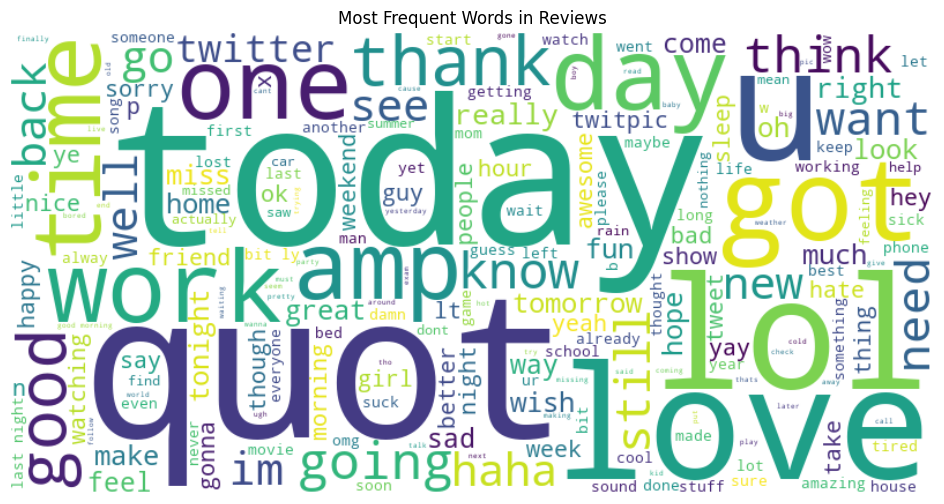

In [4]:
# ☁️ WordCloud
all_words = " ".join(df['clean_review'])
wc = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Reviews")
plt.show()
wc.to_file("wordcloud.png")

# 🔠 TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_review'])
y = df['sentiment']

Logistic Regression Accuracy: 0.7516

Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74      4934
           1       0.75      0.77      0.76      5066

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



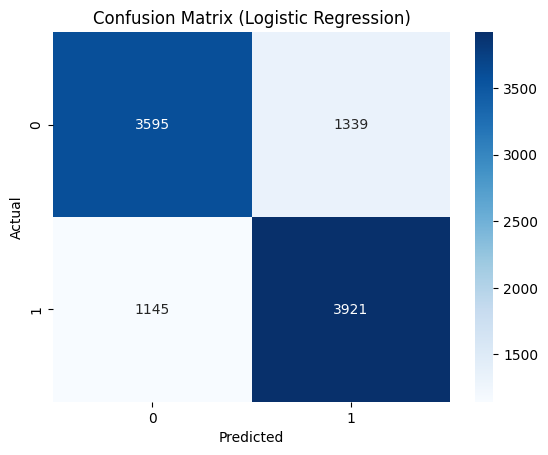

In [5]:
# ✂️ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🚀 Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print("\nReport:\n", classification_report(y_test, lr_pred))
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

Naive Bayes Accuracy: 0.7391

Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73      4934
           1       0.74      0.75      0.74      5066

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



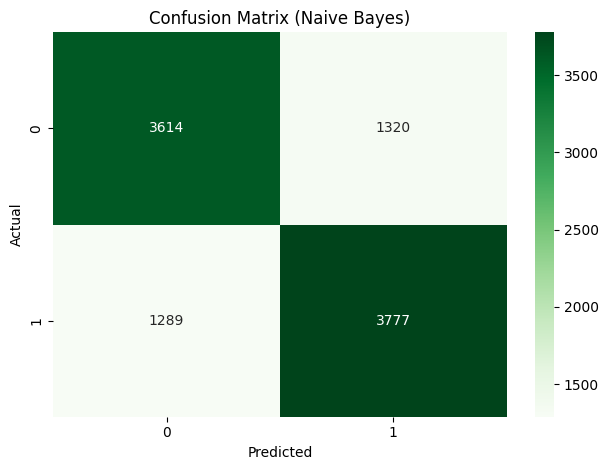

In [6]:
# 🧠 Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = pd.Series(nb_model.predict(X_test)).reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print("\nReport:\n", classification_report(y_test, nb_pred))
sns.heatmap(confusion_matrix(y_test, nb_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Naive Bayes)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_nb.png")
plt.show()

In [7]:
# 💾 Export predictions
output_df = pd.DataFrame({
    'Original Review': df['reviewText'].iloc[-len(y_test):].values,
    'Cleaned Review': df['clean_review'].iloc[-len(y_test):].values,
    'Actual': y_test,
    'Predicted': nb_pred
})
output_df.to_csv("sentiment_predictions.csv", index=False)